[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Using YOLO for Early Intrusion Detection System**

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/<BLOG_NAME>)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
[![Scientific Paper](https://img.shields.io/badge/Official-Paper-blue.svg)](<PAPER LINK>)

## **INSTALLING REQUIRED LIBRARIES**

In [ ]:
!pip install ultralytics opencv-python-headless numpy shapely

## **IMPORTING LIBRARIES**

In [1]:
# Import libraries
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon


# ***BUILDING INTRUSION DETECTION SYSTEM IN REAL-TIME***

### **FUNCTION TO STORE THE RESTRICTIVE ZONE FROM USER IN FRAME**

In [2]:
def select_polygon(video_path):
    """
    Interactive tool to define polygon by clicking on video frame
    Returns: list of polygon points in image coordinates
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return []
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, 30)  # Start from frame 30 for better visibility
    
    # Read first frame
    success, frame = cap.read()
    if not success:
        print("Error reading video frame")
        return []
    
    # Setup window in full screen mode
    window_name = "Define Restricted Area - Press ESC when done"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    # Create a copy of the frame for drawing (we'll keep original intact)
    display_frame = frame.copy()
    points = []
    
    # Function to update the display
    def update_display():
        nonlocal display_frame, frame, points
        display_frame = frame.copy()
        
        # Draw instructions
        instructions = [
            "INSTRUCTIONS:",
            "1. Click to add polygon vertices",
            "2. Press 'd' to delete last point",
            "3. Press 'c' to clear all points",
            "4. Press ENTER when finished",
            "5. Press ESC to quit"
        ]
        
        for i, text in enumerate(instructions):
            cv2.putText(display_frame, text, (10, 30 + i*30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        # Draw points and polygon
        if len(points) > 0:
            for i, (px, py) in enumerate(points):
                cv2.circle(display_frame, (px, py), 8, (0, 0, 255), -1)
                cv2.putText(display_frame, str(i+1), (px+15, py-15), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)
            
            if len(points) > 1:
                cv2.polylines(display_frame, [np.array(points)], False, (0, 255, 0), 2)
        
        cv2.imshow(window_name, display_frame)
    
    # Mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal points
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            update_display()
    
    cv2.setMouseCallback(window_name, mouse_callback)
    
    # Initial display
    update_display()
    
    while True:
        key = cv2.waitKey(0)  # Wait for key press
        
        if key == 13 or key == 10:  # ENTER key (Finish)
            if len(points) >= 3:
                break
            else:
                print("Need at least 3 points for a polygon")
        elif key == ord('d'):  # Delete last point
            if points:
                points.pop()
                update_display()
        elif key == ord('c'):  # Clear all
            points = []
            update_display()
        elif key == 27:  # ESC key (Quit)
            points = []
            break
    
    cap.release()
    cv2.destroyAllWindows()
    return points

In [10]:
# VIDEO SETUP
video_path = r"video\1.mp4"  # Replace with your video file
output_path = "output_video.mp4"

# TRESPASS SETTINGS
trespass_class_id = 0  # COCO class ID for 'person'
min_confidence = 0.5   # Minimum detection confidence

# INTERACTIVELY SELECT POLYGON
print("Starting polygon selection...")
polygon_points = select_polygon(video_path)

if not polygon_points:
    print("No polygon defined. Exiting.")
    exit()

print(f"Polygon defined with {len(polygon_points)} points:")
print(polygon_points)

# Create Shapely polygon
trespass_polygon = Polygon(polygon_points)


Starting polygon selection...
Polygon defined with 10 points:
[(1842, 668), (1032, 309), (496, 532), (714, 840), (441, 1005), (442, 1030), (404, 1060), (432, 1078), (1665, 1078), (1844, 669)]


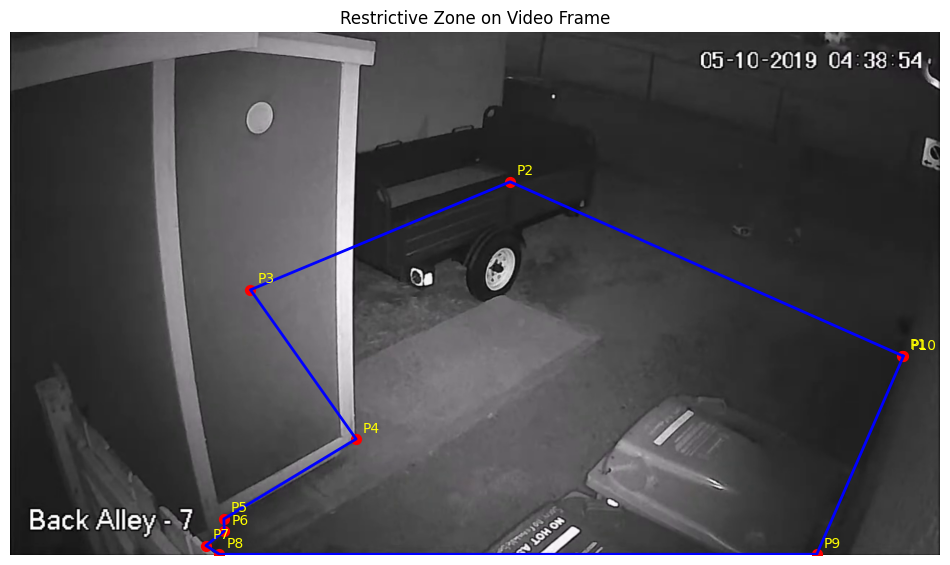

In [11]:
points = polygon_points

# Load a specific frame from your video
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 30)  # Set to desired frame
ret, frame = cap.read()
cap.release()

# Convert BGR to RGB for matplotlib
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Plot the frame with points
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)

# Extract x and y coordinates
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]

# Plot points
plt.scatter(x_coords, y_coords, c='red', s=50, marker='o')

# Connect points in index order
plt.plot(x_coords, y_coords, c='blue', linestyle='-', linewidth=2)

# Optional: Add point labels
for i, (x, y) in enumerate(points):
    plt.annotate(f'P{i+1}', (x, y), xytext=(5, 5), 
                textcoords='offset points', color='yellow')

plt.title('Restrictive Zone on Video Frame')
plt.axis('off')  # Hide axes for cleaner look
plt.show()

### **FUNCTION TO DETECT IF OBJECT IS INSIDE THE RESTRICTIVE ZONE**

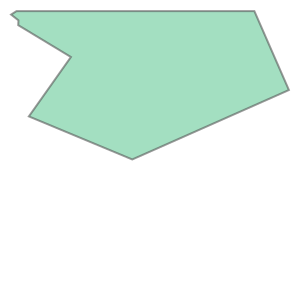

In [12]:
trespass_polygon = Polygon(polygon_points)

trespass_polygon


In [7]:
# Initialize YOLOv8 model
# Using 'yolov8m.pt' for speed and accuracy
model = YOLO('yolov8m.pt')


In [8]:
# [Video Processing]
def process_video():
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Video writer setup
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_num = 0
    trespass_detected = False
    
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
            
        frame_num += 1
        print(f"Processing frame {frame_num}/{frame_count}", end='\r')
        
        # Draw polygon on frame
        cv2.polylines(frame, [np.array(polygon_points)], True, (0, 0, 255), 2)
        cv2.putText(frame, "Restricted Area", 
                   (polygon_points[0][0], polygon_points[0][1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        # Run YOLO inference
        results = model(frame, verbose=False, classes=[trespass_class_id])[0]
        
        current_trespass = False
        
        for box in results.boxes:
            conf = float(box.conf)
            if conf < min_confidence:
                continue
                
            # Get bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Calculate bottom-center point (feet position)
            feet_x = (x1 + x2) // 2
            feet_y = y2
            
            # Check if point is inside polygon
            point = Point(feet_x, feet_y)
            if trespass_polygon.contains(point):
                current_trespass = True
                trespass_detected = True
                
                # Draw trespasser bounding box (red)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(frame, f'Trespasser: {conf:.2f}', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                
                # Draw feet position marker
                cv2.circle(frame, (feet_x, feet_y), 8, (0, 0, 255), -1)
            
            else:
                
                # Draw bounding box for non-trespassers (green)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f'Person: {conf:.2f}', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                
                # Draw feet position marker
                cv2.circle(frame, (feet_x, feet_y), 8, (0, 255, 0), -1) 
        
        # Display global warning if trespassing detected
        if current_trespass:
            cv2.putText(frame, "TRESPASSING DETECTED!", (width//6, 50),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        
        # Write frame to output video
        out.write(frame)
    
    cap.release()
    out.release()
    
    if trespass_detected:
        print("\nTrespassing detected in video!")
    else:
        print("\nNo trespassing detected")
    print(f"Output saved to: {output_path}")


In [13]:
# [Run the Detection]
process_video()

Processing frame 440/440
Trespassing detected in video!
Output saved to: output_video.mp4
